# Figures to accompany in vivo fMRS data

## Statistical results - paired t-test

In [1]:
import pandas as pd
from pathlib import Path
fixed_path = Path('group_results') / 'fixed_paired'
var_path = Path('group_results') / 'var_paired'

group_stats_fixed = pd.read_csv(fixed_path / 'group_stats.csv', index_col=0, header=[0, 1])
group_stats_var = pd.read_csv(var_path / 'group_stats.csv', index_col=0, header=[0, 1])

In [385]:
combined_peaks = ['NAA', 'NAAG', 'Cr', 'PCr', 'PCho', 'GPC']

format = {
    ('COPE', 'STIM>CTRL'): '{:.2e}',
    ('COPE', 'CTRL>STIM'): '{:.2e}',
    ('VARCOPE', 'STIM>CTRL'): '{:.2e}',
    ('VARCOPE', 'CTRL>STIM'): '{:.2e}',
}
def style_sig(v, props=''):
    return props if v < 0.05 else None
def filter_results(res_df):
    filtered = res_df.filter(regex=r'.*_mean_activation', axis=0)
    filtered = filtered.drop([f'conc_{x}_mean_activation' for x in combined_peaks])
    filtered.index = filtered.index.str.replace('conc_', '')
    filtered.index = filtered.index.str.replace('_mean_activation', '')
    return filtered.style\
        .format(format, precision=2)\
        .applymap(style_sig, props='color:red;', subset='p')\
        .set_table_styles([dict(selector='th.col_heading.level0', props=[('text-align', 'center')])])

dffixed = filter_results(group_stats_fixed)
dffixed

In [388]:
import dataframe_image as dfi
dfi.export(dffixed, '../../publication/figures/st2_invivo_fmrs_fixed.png', table_conversion="selenium")


In [389]:
dfvar = filter_results(group_stats_var)
dfi.export(dfvar, '../../publication/figures/st1_invivo_fmrs_var.png', table_conversion="selenium")
dfvar

In [5]:
def filter_lw(res_df):
    filtered = res_df.filter(regex=r'(sigma_0)|(gamma_0)', axis=0)
    return filtered.style\
        .format(format, precision=2)\
        .applymap(style_sig, props='color:red;', subset='p')

filter_lw(group_stats_fixed)

In [6]:
filter_lw(group_stats_var)

## Visualisation - group means

### Load all the datasets

In [141]:
var_path = Path('group_results') / 'var_group_mean'
group_mean_var = pd.read_csv(var_path / 'group_stats.csv', index_col=0, header=[0, 1])

fixed_path = Path('group_results') / 'fixed_group_mean'
group_mean_fixed = pd.read_csv(fixed_path / 'group_stats.csv', index_col=0, header=[0, 1])

def filter_mean(df):
    mean_filtered = df\
        .filter(regex=r'conc_[\w+]*_((STIM\d{1})|(linear)|(constant))', axis=0)\
        .filter(like='COPE')\
        .filter(like='+ve')\
        .rename(index=lambda x: x.replace('conc_', ''))\
        .rename(columns=lambda x: x.replace(' +ve', ''))\
        .reorder_levels([1, 0], axis=1)
    mean_filtered.index = mean_filtered.index.str.split('_', expand=True)
    return mean_filtered.sort_index(axis=1)

filtered_var = filter_mean(group_mean_var)
filtered_fix = filter_mean(group_mean_fixed)


per_sub_df_raw = {f'P{x:03.0f}': [] for x in range(1, 14)}
for file in var_path.rglob('free_parameters.csv'):
    curr_df = pd.read_csv(file, index_col=0, header=[0])
    curr_df.sd = curr_df.sd.pow(2)
    idx, pt = file.parent.name.split('_')
    if int(idx) < 13:
        curr_df = pd.concat({'open': curr_df.T}, names=['Contrasts']).T
        per_sub_df_raw[pt].append(curr_df)
    else:
        curr_df = pd.concat({'closed': curr_df.T}, names=['Contrasts']).T
        per_sub_df_raw[pt].append(curr_df)

def filter_single(df):
    filtered = df.filter(regex=r'conc_[\w+]*_((STIM\d{1})|(linear)|(constant))', axis=0)\
        .rename(index=lambda x: x.replace('conc_', ''))\
        .rename(columns={'mean': 'COPE', 'sd': 'VARCOPE'})
    filtered.index = filtered.index.str.split('_', expand=True)
    return filtered

per_sub_df = {}
for key, item in per_sub_df_raw.items():
    per_sub_df[key] = filter_single(pd.concat(item, axis=1))


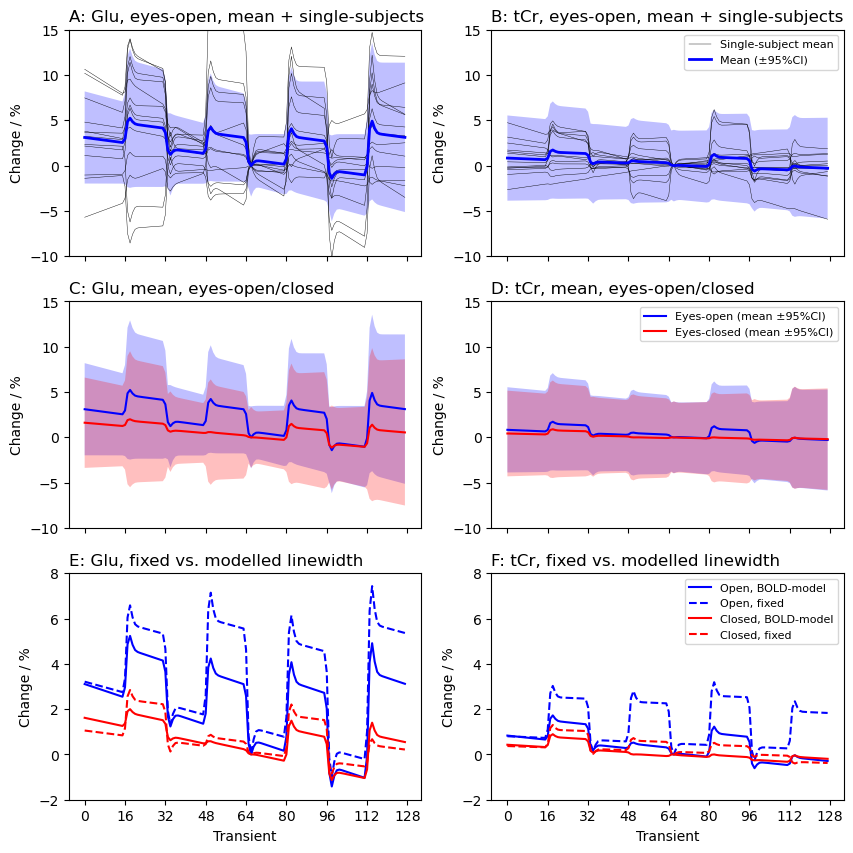

In [33]:
designmat = pd.read_csv('design_matrix.csv', header=None)

def generate_traces(filt_df, metab, condition, rel=False):
    mean_df = filt_df.loc[metab, condition].COPE
    mean = designmat.to_numpy() @ mean_df.to_numpy()

    sd_df = filt_df.loc[metab, condition].VARCOPE.pow(0.5)
    sd = np.abs(designmat.to_numpy()) @ sd_df.to_numpy()
    ci = sd * 1.96
    if rel:
        mean_perc = mean / mean_df.constant
        mean_perc -= mean_perc[66]
        mean_perc *= 100
        ci_perc = 100 * ci / mean_df.constant
        return mean_perc, mean_perc + ci_perc, mean_perc - ci_perc
    else:
        return mean, mean + ci, mean - ci

import  matplotlib.pyplot as plt
import numpy as np

def plot_trace(df, metab, condition, ax, var=False, color='k', lw=1.5, style='-', label=None, rel=True):
    mean, pos_err, neg_err = generate_traces(
        df,
        metab,
        condition,
        rel)

    x_fill = np.arange(0,128).tolist()+np.flip(np.arange(0, 128)).tolist()
    y_fill = pos_err.tolist() + np.flip(neg_err).tolist()
    if var:
        ax.fill_between(x_fill, y_fill, alpha=0.25, facecolor=color)
    ax.plot(mean, color, linewidth=lw, linestyle=style, label=label)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True)

metab1 = "Glu"
metab2 = "Cr+PCr"

# First panel (Glu with single subjects)
for sub in per_sub_df:
    plot_trace(per_sub_df[sub], metab1, 'open', axes[0][0], var=False, color='k', lw=0.3)
plot_trace(filtered_var, metab1, 'open', axes[0][0], var=True, color='b', lw=2)


# second panel (tNAA with single subjects)
for idx, sub in enumerate(per_sub_df):
    if idx == 0:
        plot_trace(per_sub_df[sub], metab2, 'open', axes[0][1], var=False, color='k', lw=0.3, label='Single-subject mean')
    else:
        plot_trace(per_sub_df[sub], metab2, 'open', axes[0][1], var=False, color='k', lw=0.3)
plot_trace(filtered_var, metab2, 'open', axes[0][1], var=True, color='b', lw=2, label='Mean (±95%CI)')


# third panel (Glu opne/closed)
plot_trace(filtered_var, metab1, 'open', axes[1][0], var=True, color='b')
plot_trace(filtered_var, metab1, 'closed', axes[1][0], var=True, color='r')

# Fourth panel (tNAA opne/closed)
plot_trace(filtered_var, metab2, 'open', axes[1][1], var=True, color='b', label='Eyes-open (mean ±95%CI)')
plot_trace(filtered_var, metab2, 'closed', axes[1][1], var=True, color='r', label='Eyes-closed (mean ±95%CI)')


# Fifth panel (Glu var/fixed)
plot_trace(filtered_var, metab1, 'open', axes[2][0], var=False, color='b', label='Open, variable')
plot_trace(filtered_fix, metab1, 'open', axes[2][0], var=False, color='b', style='--', label='Open, fixed')
plot_trace(filtered_var, metab1, 'closed', axes[2][0], var=False, color='r', label='Closed, variable')
plot_trace(filtered_fix, metab1, 'closed', axes[2][0], var=False, color='r', style='--', label='Closed, fixed')

plot_trace(filtered_var, metab2, 'open', axes[2][1], var=False, color='b', label='Open, BOLD-model')
plot_trace(filtered_fix, metab2, 'open', axes[2][1], var=False, color='b', style='--', label='Open, fixed')
plot_trace(filtered_var, metab2, 'closed', axes[2][1], var=False, color='r', label='Closed, BOLD-model')
plot_trace(filtered_fix, metab2, 'closed', axes[2][1], var=False, color='r', style='--', label='Closed, fixed')

for ax in axes.ravel():
    ax.set_ylim([-10, 15])
    ax.set_ylabel('Change / %')
    ax.set_xticks(np.arange(0,129,16))

axes[2][0].set_ylim([-2, 8])
axes[2][1].set_ylim([-2, 8])

axes[2][0].set_xlabel('Transient')
axes[2][1].set_xlabel('Transient')

axes[0][0].set_title('A: Glu, eyes-open, mean + single-subjects', fontsize=12, loc='left')
axes[0][1].set_title('B: tCr, eyes-open, mean + single-subjects', fontsize=12, loc='left')
axes[1][0].set_title('C: Glu, mean, eyes-open/closed', fontsize=12, loc='left')
axes[1][1].set_title('D: tCr, mean, eyes-open/closed', fontsize=12, loc='left')
axes[2][0].set_title('E: Glu, fixed vs. modelled linewidth', fontsize=12, loc='left')
axes[2][1].set_title('F: tCr, fixed vs. modelled linewidth', fontsize=12, loc='left')

axes[0][1].legend(fontsize=8, loc='upper right')
axes[1][1].legend(fontsize=8, loc='upper right')
axes[2][1].legend(fontsize=8, loc='upper right')

plt.savefig('../../publication/figures/fig7_invivo_fmrs.png', dpi=400, bbox_inches='tight', transparent=True)


### Calculate the % increases observed 

In [10]:
def filter_mean_activation(df):
    mean_filtered = df\
        .filter(regex=r'conc_[\w+]*_((mean_activation)|(constant))', axis=0)\
        .filter(like='COPE')\
        .filter(like='+ve')\
        .rename(index=lambda x: x.replace('conc_', ''))\
        .rename(index=lambda x: x.replace('mean_activation', 'MeanActivation'))\
        .rename(columns=lambda x: x.replace(' +ve', ''))\
        .reorder_levels([1, 0], axis=1)
    mean_filtered.index = mean_filtered.index.str.split('_', expand=True)
    return mean_filtered.sort_index(axis=1)

def calc_percentage(df):
    const_terms = df.xs('constant', level=1, drop_level=True)
    ma_terms = df.xs('MeanActivation', level=1, drop_level=True)
    per = (100 * ma_terms / const_terms)
    return per

per_Var = calc_percentage(filter_mean_activation(group_mean_var))
print(per_Var.loc[['Glu','NAA+NAAG','Cr+PCr','PCho+GPC'],(('open', 'closed'), 'COPE')])
print(per_Var.loc[['Glu','NAA+NAAG','Cr+PCr','PCho+GPC'],(('open', 'closed'), 'VARCOPE')].pow(0.5))

per_fixed = calc_percentage(filter_mean_activation(group_mean_fixed))
print(per_fixed.loc[['Glu','NAA+NAAG','Cr+PCr','PCho+GPC'],(('open', 'closed'), 'COPE')])
print(per_fixed.loc[['Glu','NAA+NAAG','Cr+PCr','PCho+GPC'],(('open', 'closed'), 'VARCOPE')].pow(0.5))



Contrast        open    closed
Statistics      COPE      COPE
Glu         3.085670  1.045319
NAA+NAAG   -0.327322 -0.508665
Cr+PCr      0.633295  0.185998
PCho+GPC   -0.120627 -0.905622
Contrast        open    closed
Statistics   VARCOPE   VARCOPE
Glu         5.852725  5.821393
NAA+NAAG    1.079668  1.070822
Cr+PCr      1.122402  1.109794
PCho+GPC    2.321176  2.291341
Contrast        open    closed
Statistics      COPE      COPE
Glu         4.373503  1.233121
NAA+NAAG    0.431533 -0.368301
Cr+PCr      1.857867  0.323196
PCho+GPC    1.873415 -0.560196
Contrast        open    closed
Statistics   VARCOPE   VARCOPE
Glu         5.856615  5.821754
NAA+NAAG    1.042918  1.034901
Cr+PCr      1.148766  1.139392
PCho+GPC    2.283151  2.253472


## Generate supporting figure for linewidths

/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/ipykernel_83840/3216046756.py:94: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  norm_var_lw.loc[:, ('closed', 'COPE')] = out_cope_closed[0][:-1]
/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/ipykernel_83840/3216046756.py:95: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  norm_var_lw.loc[:, ('closed', 'VARCOPE')] = out_varcope_closed[0][:-1]
/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/ipykernel_83840/3216046756.py:96: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

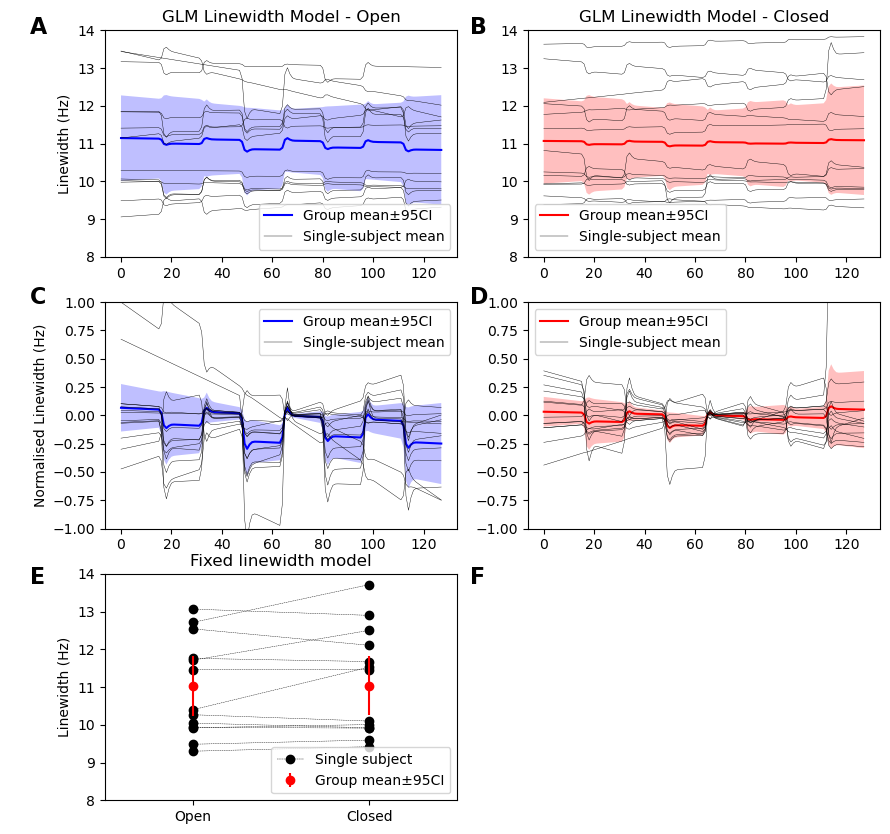

In [378]:
def filter_lw(df):
    mean_filtered = df\
        .filter(regex=r'gamma_0_((STIM\d{1})|(linear)|(constant))', axis=0)\
        .filter(like='COPE')\
        .filter(like='+ve')\
        .rename(index=lambda x: x.replace('gamma_0', 'lw'))\
        .rename(columns=lambda x: x.replace(' +ve', ''))\
        .reorder_levels([1, 0], axis=1)
    mean_filtered.index = mean_filtered.index.str.split('_', expand=True)
    return mean_filtered.sort_index(axis=1)

# Include the sigma term by adding the combined to the constant
raw_sigma_var = group_mean_var\
    .filter(regex='sigma_0_*',axis=0)\
    .filter(like='COPE')\
    .filter(like='+ve')\
    .rename(columns=lambda x: x.replace(' +ve', '')).loc['sigma_0', 'COPE']
scaled_var_lw = filter_lw(group_mean_var).divide(np.pi)
gamma_baseline = scaled_var_lw.loc['lw', :].loc['constant'].xs('COPE', level=1)

# From the equation at https://git.fmrib.ox.ac.uk/fsl/fsl_mrs/-/blob/master/fsl_mrs/utils/results.py#L745
scaled_sigma_var = 2.335 / (2 * np.pi * (np.sqrt(0.5) / raw_sigma_var))
combined_constant = 0.5346 * gamma_baseline + np.sqrt(0.2166 * gamma_baseline.pow(2) + scaled_sigma_var.pow(2))


scaled_var_lw.loc[('lw', 'constant'), ('open','COPE')] = combined_constant.open
scaled_var_lw.loc[('lw', 'constant'), ('closed','COPE')] = combined_constant.closed

## Single subject
# Variable
def filter_singlelw_gamma(df):
    filtered = df.filter(regex=r'gamma_0_((STIM\d{1})|(linear)|(constant))', axis=0)\
        .rename(index=lambda x: x.replace('gamma_0', 'lw'))\
        .rename(columns={'mean': 'COPE', 'sd': 'VARCOPE'})
    filtered.index = filtered.index.str.split('_', expand=True)
    return filtered.divide(np.pi)
def filter_singlelw_sigma(df):
    filtered = df.filter(regex=r'sigma_0', axis=0).loc['sigma_0',:].xs('mean', level=1)
    return 2.335 / (2 * np.pi * (np.sqrt(0.5) / filtered))


per_sub_lw = {}
for key, item in per_sub_df_raw.items():
    scaled_sigma = filter_singlelw_sigma(pd.concat(item, axis=1))
    per_sub_lw[key] = filter_singlelw_gamma(pd.concat(item, axis=1))
    gamma_baseline = per_sub_lw[key].loc['lw', :].loc['constant'].xs('COPE', level=1)

    combined_constant = 0.5346 * gamma_baseline + np.sqrt(0.2166 * gamma_baseline.pow(2) + scaled_sigma.pow(2))
    per_sub_lw[key].loc[('lw', 'constant'), ('open','COPE')] = combined_constant.open
    per_sub_lw[key].loc[('lw', 'constant'), ('closed','COPE')] = combined_constant.closed

# Recalculate the mean after zeroing the constant term
per_sub_lw_norm = {}
per_sub_lw_norm_fortest = {}
idx = pd.IndexSlice
for sub in per_sub_lw:
    tmp = per_sub_lw[sub].copy()
    tmp.loc[idx[:, 'constant'],:] = 0
    per_sub_lw_norm[sub] = tmp.copy()
    tmp.loc[('lw', 'Mean'), idx[:,'COPE']] = tmp.filter(regex='STIM', axis=0).loc[:, idx[:, 'COPE']].mean()
    tmp.loc[('lw', 'Mean'), idx[:,'VARCOPE']] = tmp.filter(regex='STIM', axis=0).loc[:, idx[:, 'VARCOPE']].multiply(0.25**2).sum()
    per_sub_lw_norm_fortest[sub] = tmp

import fsl_mrs.utils.fmrs_tools as ftools
copes_open = []
varcopes_open = []
copes_closed = []
varcopes_closed = []
for sub in per_sub_lw_norm:
    copes_open.append(
        per_sub_lw_norm_fortest[sub].loc[idx['lw',:], idx['open', 'COPE']].to_numpy())
    varcopes_open.append(
        per_sub_lw_norm_fortest[sub].loc[idx['lw',:], idx['open', 'VARCOPE']].pow(2).to_numpy())
    copes_closed.append(
        per_sub_lw_norm_fortest[sub].loc[idx['lw',:], idx['closed', 'COPE']].to_numpy())
    varcopes_closed.append(
        per_sub_lw_norm_fortest[sub].loc[idx['lw',:], idx['closed', 'VARCOPE']].pow(2).to_numpy())
    
copes_open = np.stack(copes_open)
varcopes_open = np.stack(varcopes_open)

p_open, z_open, out_cope_open, out_varcope_open = ftools.flameo_wrapper(
    copes_open,
    varcopes_open)

copes_closed = np.stack(copes_closed)
varcopes_closed = np.stack(varcopes_closed)

p_closed, z_closed, out_cope_closed, out_varcope_closed = ftools.flameo_wrapper(
    copes_closed,
    varcopes_closed)

norm_var_lw = scaled_var_lw.copy()
norm_var_lw.loc[:, ('closed', 'COPE')] = out_cope_closed[0][:-1]
norm_var_lw.loc[:, ('closed', 'VARCOPE')] = out_varcope_closed[0][:-1]
norm_var_lw.loc[:, ('open', 'COPE')] = out_cope_open[0][:-1]
norm_var_lw.loc[:, ('open', 'VARCOPE')] = out_varcope_open[0][:-1]




# # Ploting

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=False)

#  row 1 left - open single subjects + mean
plot_trace(scaled_var_lw, 'lw', 'open', axes[0][0], var=True, color='b', label='Group mean±95CI', rel=False)

for idx, sub in enumerate(per_sub_lw):
    if idx == 0:
        plot_trace(per_sub_lw[sub], 'lw', 'open', axes[0][0], var=False, color='k', lw=0.3, label='Single-subject mean', rel=False)
    else:
        plot_trace(per_sub_lw[sub], 'lw', 'open', axes[0][0], var=False, color='k', lw=0.3, rel=False)

#  row 2 left - normalised
plot_trace(norm_var_lw, 'lw', 'open', axes[1][0], var=True, color='b', label='Group mean±95CI', rel=False)

for idx, sub in enumerate(per_sub_lw_norm):
    if idx == 0:
        plot_trace(per_sub_lw_norm[sub], 'lw', 'open', axes[1][0], var=False, color='k', lw=0.3, label='Single-subject mean', rel=False)
    else:
        plot_trace(per_sub_lw_norm[sub], 'lw', 'open', axes[1][0], var=False, color='k', lw=0.3, rel=False)

# row 1 right - closed single subjects + mean
plot_trace(scaled_var_lw, 'lw', 'closed', axes[0][1], var=True, color='r', label='Group mean±95CI', rel=False)

for idx, sub in enumerate(per_sub_lw):
    if idx == 0:
        plot_trace(per_sub_lw[sub], 'lw', 'closed', axes[0][1], var=False, color='k', lw=0.3, label='Single-subject mean', rel=False)
    else:
        plot_trace(per_sub_lw[sub], 'lw', 'closed', axes[0][1], var=False, color='k', lw=0.3, rel=False)


#  row 2 right - normalised
plot_trace(norm_var_lw, 'lw', 'closed', axes[1][1], var=True, color='r', label='Group mean±95CI', rel=False)

for idx, sub in enumerate(per_sub_lw_norm):
    if idx == 0:
        plot_trace(per_sub_lw_norm[sub], 'lw', 'closed', axes[1][1], var=False, color='k', lw=0.3, label='Single-subject mean', rel=False)
    else:
        plot_trace(per_sub_lw_norm[sub], 'lw', 'closed', axes[1][1], var=False, color='k', lw=0.3, rel=False)




# plot_trace(scaled_fixed_lw, 'lw', 'open', axes[2][0], var=False, color='b',style='--', label='Open, fixed', rel=False)
# plot_trace(scaled_fixed_lw, 'lw', 'closed', axes[3][0], var=False, color='r',style='--', label='Closed, fixed', rel=False)

for aa in axes[0]:
    aa.set_ylim([8, 14])
    aa.legend()
for aa in axes[1]:
    aa.set_ylim([-1, 1])
    aa.legend()

axes[0][0].set_ylabel('Linewidth (Hz)')
axes[1][0].set_ylabel('Normalised Linewidth (Hz)')

axes[0][0].set_title('GLM Linewidth Model - Open')
axes[0][1].set_title('GLM Linewidth Model - Closed')

# # Repeat for simpler fixed case

lw_fixed_filt = group_mean_fixed\
    .filter(regex='(sigma|gamma)_0_*',axis=0)\
    .filter(like='COPE')\
    .filter(like='+ve')\
    .rename(columns=lambda x: x.replace(' +ve', ''))
lw_fixed_filt.loc['gamma_0'] /= np.pi
lw_fixed_filt.loc['sigma_0'] = 2.335 / (2 * np.pi * (np.sqrt(0.5) / lw_fixed_filt.loc['sigma_0']))
fixed_comb = 0.5346 * lw_fixed_filt.loc['gamma_0','COPE'] \
    + np.sqrt(0.2166 * lw_fixed_filt.loc['gamma_0','COPE'].pow(2)
               + lw_fixed_filt.loc['sigma_0','COPE'].pow(2))
fixed_comb
fixed_sd = lw_fixed_filt.VARCOPE.loc['gamma_0'].pow(0.5)


per_sub_df_fixed_raw = {f'P{x:03.0f}': [] for x in range(1, 14)}
for file in fixed_path.rglob('free_parameters.csv'):
    curr_df = pd.read_csv(file, index_col=0, header=[0])
    curr_df.sd = curr_df.sd.pow(2)
    idx, pt = file.parent.name.split('_')
    if int(idx) < 13:
        # print(curr_df)
        curr_df = curr_df\
            .filter(regex='(sigma|gamma)_0', axis=0).loc[:,'mean']
        per_sub_df_fixed_raw[pt].append(curr_df)
    else:
        curr_df = curr_df\
            .filter(regex='(sigma|gamma)_0', axis=0).loc[:,'mean']
        per_sub_df_fixed_raw[pt].append(curr_df)
fixed_single_sub = []
for sub in per_sub_df_fixed_raw:
    def calc_combined(x):
        gamma = x.gamma_0/ np.pi
        sigma = 2.335 / (2 * np.pi * (np.sqrt(0.5) / x.sigma_0))
        return 0.5346 * gamma + np.sqrt(0.2166 * gamma**2 + sigma**2)
    fixed_single_sub.append(
        [calc_combined(per_sub_df_fixed_raw[sub][0]),
         calc_combined(per_sub_df_fixed_raw[sub][1])])

# per_sub_df_fixed_raw
for idx, ss_val in enumerate(fixed_single_sub):
    if idx == 0:
        axes[2][0].plot([1,2], ss_val, 'ko--', linewidth=0.3, label='Single subject')
    else:
        axes[2][0].plot([1,2], ss_val, 'ko--', linewidth=0.3)
axes[2][0].errorbar([1, 2],[fixed_comb.open, fixed_comb.closed],[fixed_sd.open*1.96, fixed_sd.closed*1.96],c='r', barsabove=True, fmt='o',label='Group mean±95CI')


axes[2][0].set_ylim([8, 14])
axes[2][0].set_ylabel('Linewidth (Hz)')
axes[2][0].set_xticks([1, 2])
axes[2][0].set_xticklabels(['Open', 'Closed'])
axes[2][0].set_xlim([0.5, 2.5])
axes[2][0].legend()
axes[2][0].set_title('Fixed linewidth model')

axes[2][1].axis('off')
plt.annotate('A', (0.03, 0.80), xycoords='figure fraction', fontsize=16, fontweight='bold')
plt.annotate('C', (0.03, 0.53), xycoords='figure fraction', fontsize=16, fontweight='bold')
plt.annotate('E', (0.03, 0.25), xycoords='figure fraction', fontsize=16, fontweight='bold')

plt.annotate('B', (0.47, 0.80), xycoords='figure fraction', fontsize=16, fontweight='bold')
plt.annotate('D', (0.47, 0.53), xycoords='figure fraction', fontsize=16, fontweight='bold')
plt.annotate('F', (0.47, 0.25), xycoords='figure fraction', fontsize=16, fontweight='bold')

# plt.show()
plt.savefig('../../publication/figures/s9_invivo_fmrs_lw.png', dpi=400, bbox_inches='tight', transparent=True)


In [379]:
open_lw_stats = pd.DataFrame(
            [out_cope_open[0], np.sqrt(out_varcope_open[0]), z_open[0],1-p_open[0]],
            index=['ΔLW (Hz)', 'std (Hz)', 'z stat', 'p'],
            columns=per_sub_lw_norm_fortest['P001'].index.get_level_values(1)).T

closed_lw_stats = pd.DataFrame(
            [out_cope_closed[0], np.sqrt(out_varcope_closed[0]), z_closed[0],1-p_closed[0]],
            index=['ΔLW (Hz)', 'std (Hz)', 'z stat', 'p'],
            columns=per_sub_lw_norm_fortest['P001'].index.get_level_values(1)).T

lw_results_stats = pd.concat(
    (closed_lw_stats.loc['Mean',:],
     open_lw_stats.loc['Mean',:]),
     axis=1,
     keys=['Closed', 'Open']).T

lw_results_stats_styled = lw_results_stats.style\
        .format(format, precision=3)\
        .applymap(style_sig, props='color:red;', subset='p')

dfi.export(lw_results_stats_styled, '../../publication/figures/fmrs_lw_stats.png', table_conversion="selenium", dpi=500)
lw_results_stats_styled


In [380]:
from PIL import Image
im = Image.open("../../publication/figures/s9_invivo_fmrs_lw.png")
subim = Image.open("../../publication/figures/fmrs_lw_stats.png")
im.paste(subim, (2000, 2500))
im.save("../../publication/figures/s9_invivo_fmrs_lw.png")